In [5]:
import os
import numpy as np
import rasterio as rio
from rasterio.plot import show
from rasterio.mask import mask
from shapely.geometry import mapping
from shapely.geometry import MultiLineString
import matplotlib.pyplot as plt
import geopandas as gpd
import earthpy as et
import earthpy.plot as ep
import earthpy.spatial as es
from osgeo import gdal, osr, ogr
from glob import glob
from shutil import copyfile

import json
from shapely.geometry import Polygon
import ee

ee.Initialize()

In [3]:
test_vector = "/Volumes/Lacie/zhenyadata/Project_Canopy_Data/PC_Data/Geometry/test_line_labelling/v2/ISL_2-ML/ISL_Roads_2.shp"

line_shape = gpd.read_file(test_vector)

In [4]:
line_shape

,index,width,color,note,geometry
0,0,1.0,"255,0,0,255",None,"LINESTRING (8.97233 5.75003, 8.97233 5.75003, ..."
1,1,1.0,"255,0,0,255",None,"LINESTRING (8.97158 5.75043, 8.97158 5.75043, ..."
2,2,1.0,"255,0,0,255",None,"LINESTRING (8.96902 5.75129, 8.96902 5.75129, ..."
3,3,1.0,"255,0,0,255",None,"LINESTRING (8.96903 5.75129, 8.96902 5.75129, ..."
4,4,1.0,"255,0,0,255",None,"LINESTRING (8.96876 5.75143, 8.96876 5.75143, ..."
...,...,...,...,...,...
247,176,1.0,"255,0,0,255",None,"LINESTRING (8.91890 5.77014, 8.91890 5.77012, ..."
248,177,1.0,"255,0,0,255",None,"LINESTRING (8.92489 5.74822, 8.92489 5.74822, ..."
249,178,1.0,"255,0,0,255",None,"LINESTRING (8.92475 5.74803, 8.92475 5.74803, ..."
250,179,1.0,"255,0,0,255",None,"LINESTRING (8.91676 5.75099, 8.91676 5.75099, ..."


/Users/purgatorid/.local/share/virtualenvs/processing-SJ9kIKls/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """


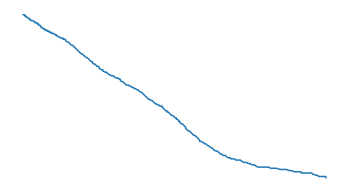

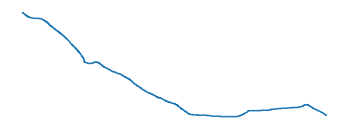

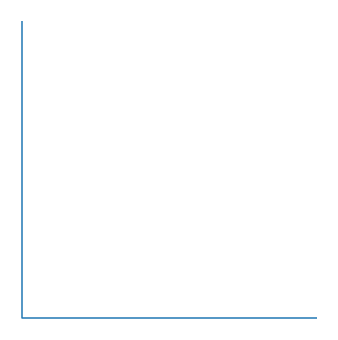

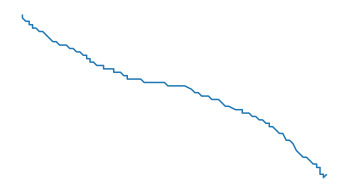

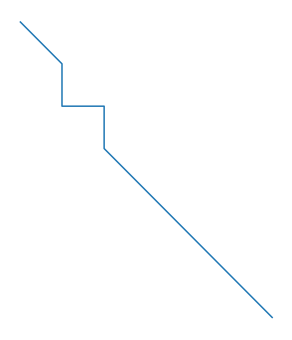

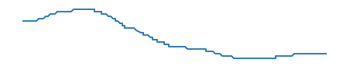

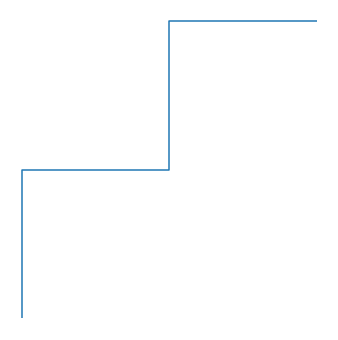

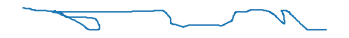

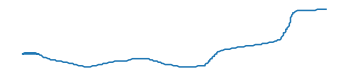

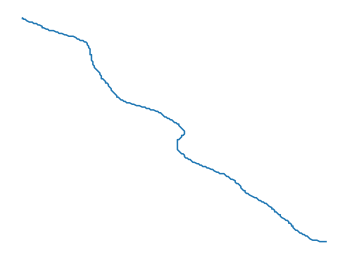

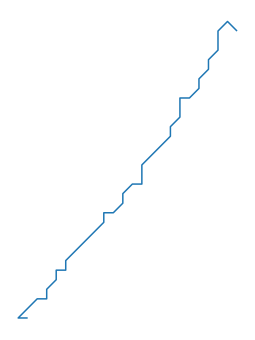

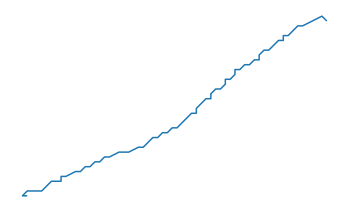

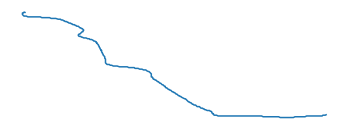

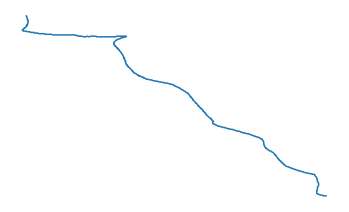

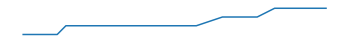

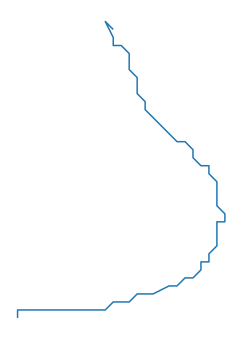

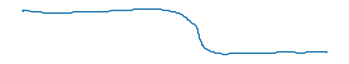

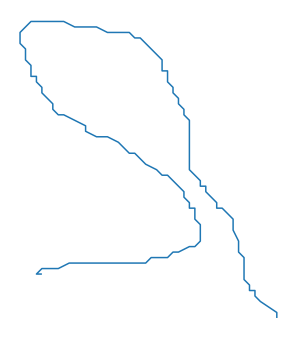

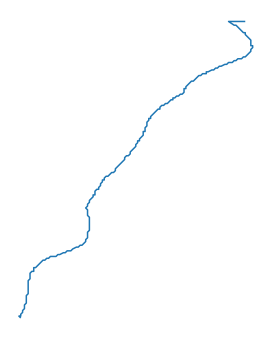

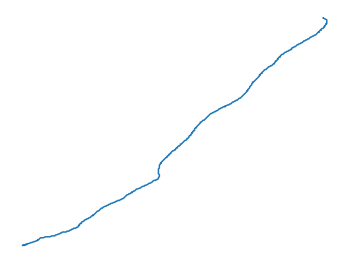

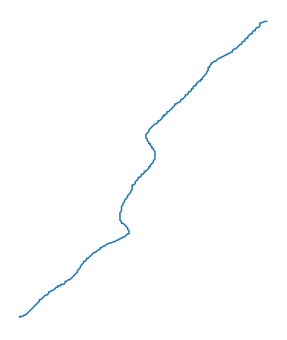

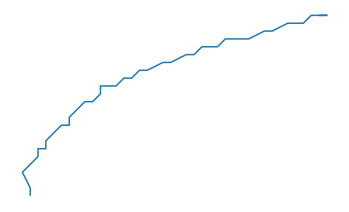

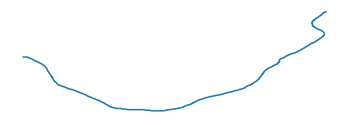

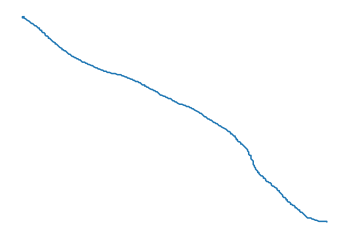

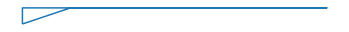

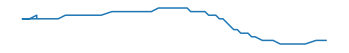

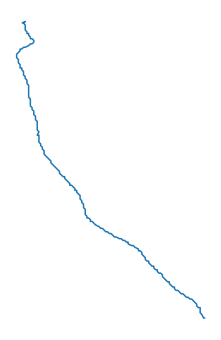

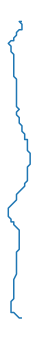

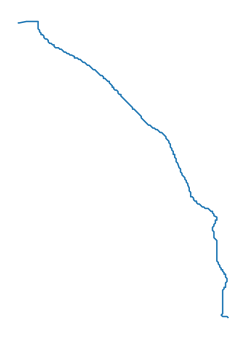

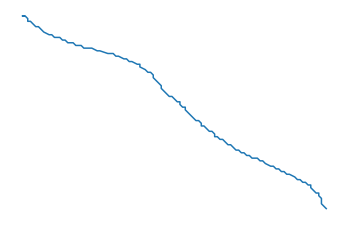

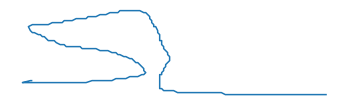

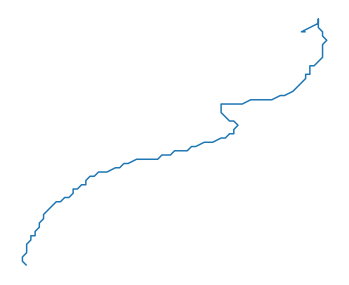

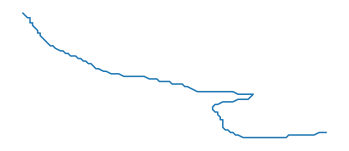

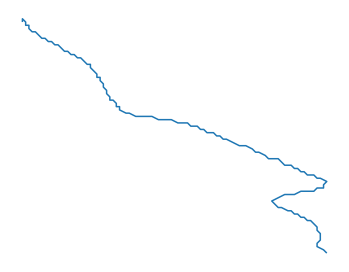

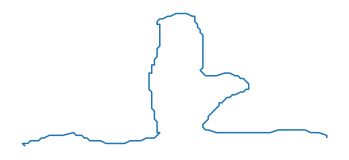

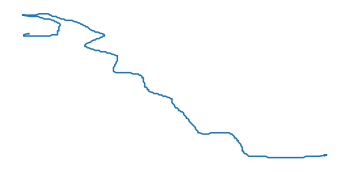

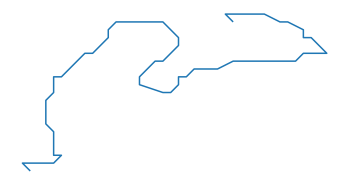

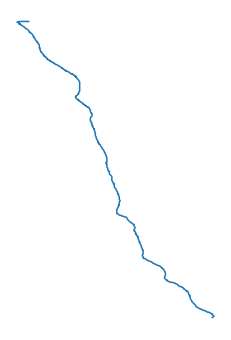

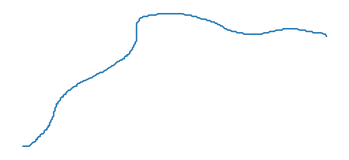

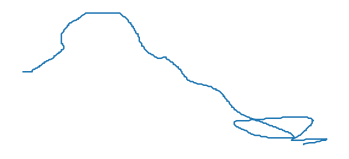

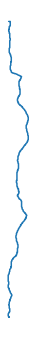

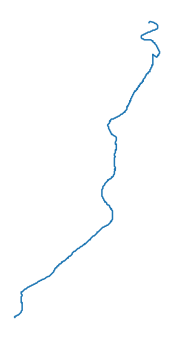

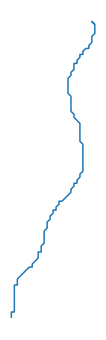

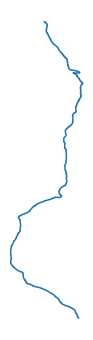

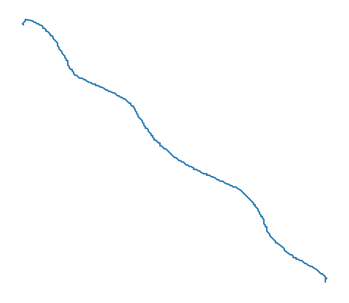

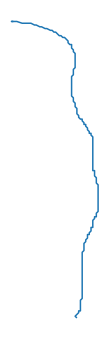

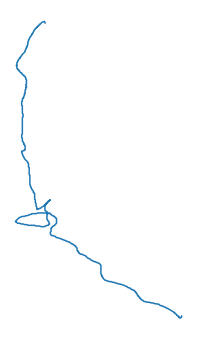

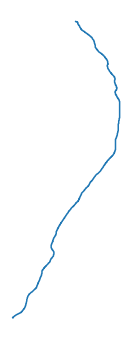

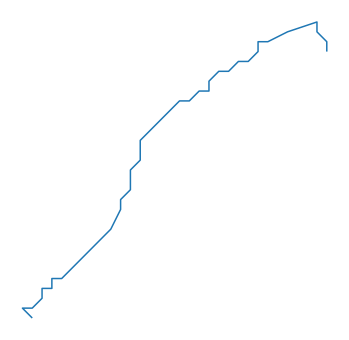

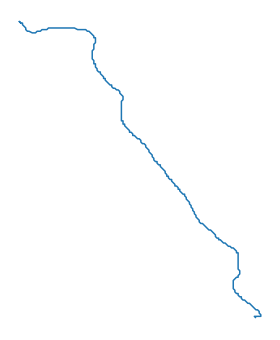

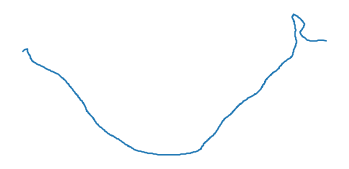

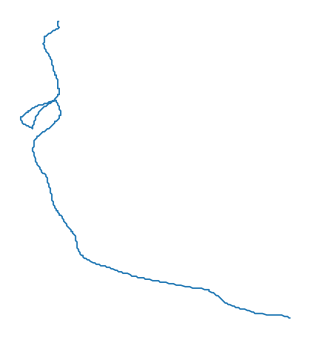

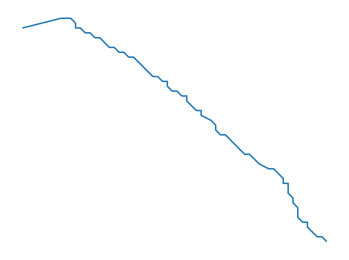

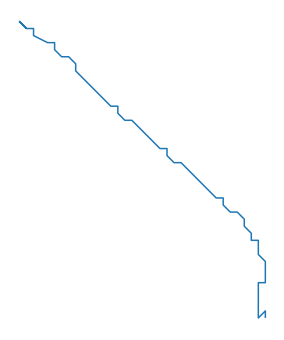

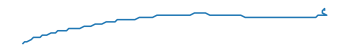

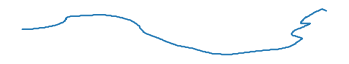

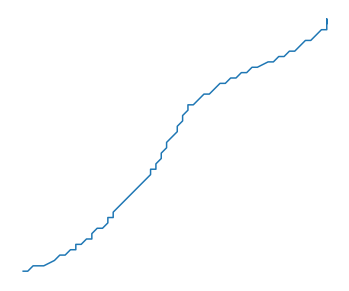

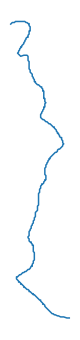

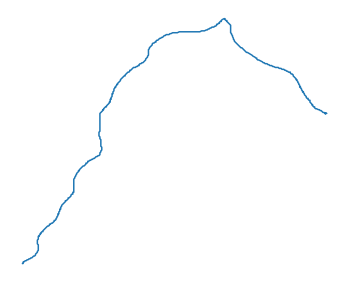

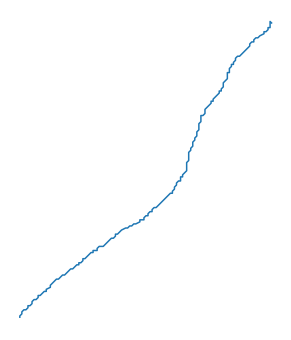

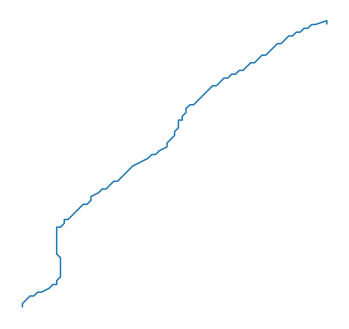

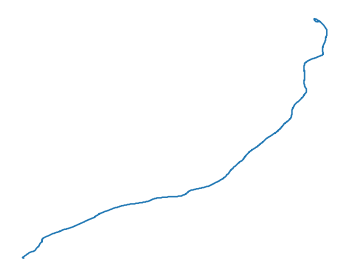

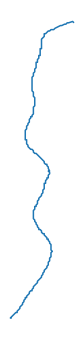

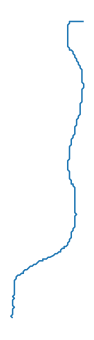

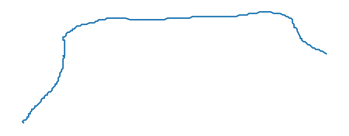

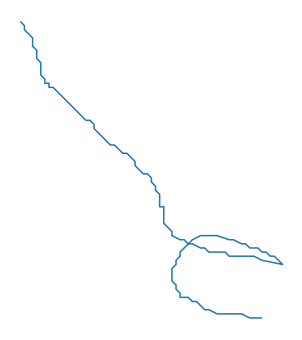

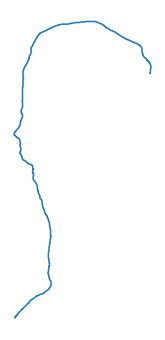

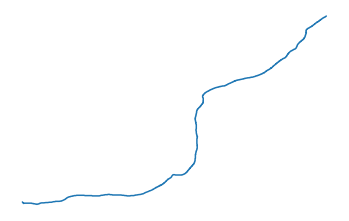

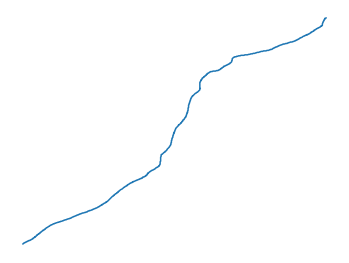

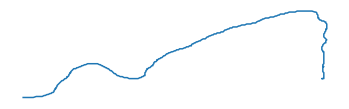

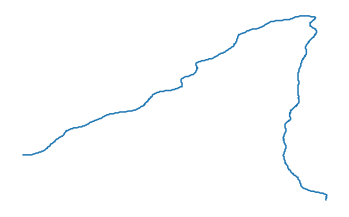

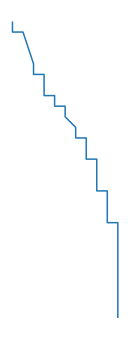

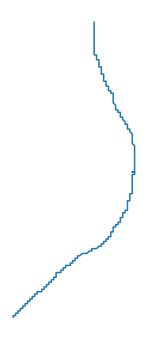

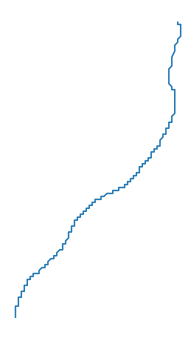

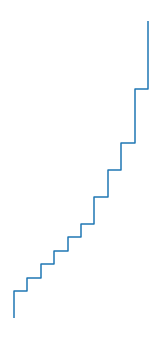

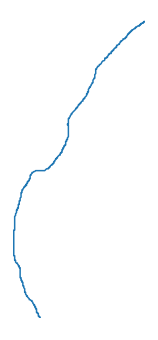

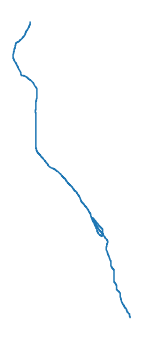

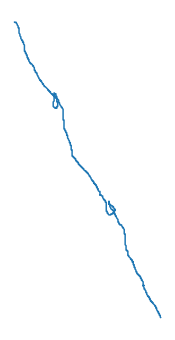

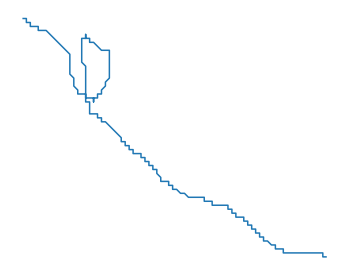

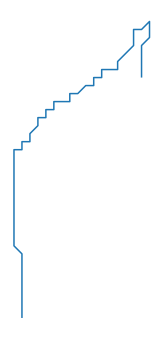

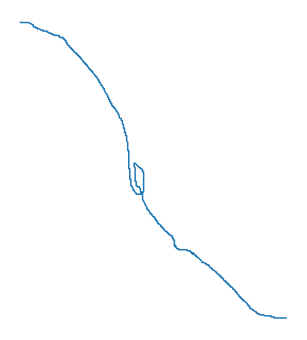

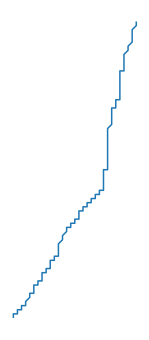

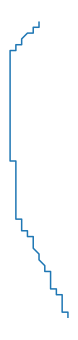

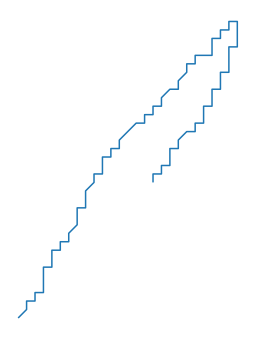

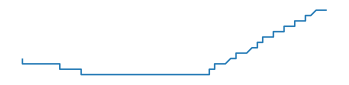

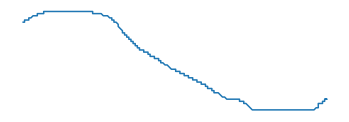

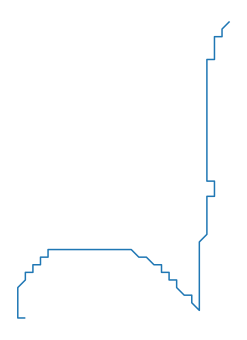

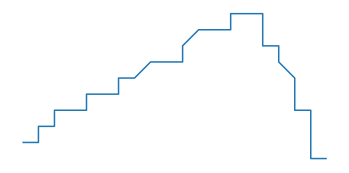

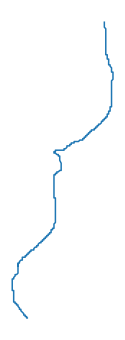

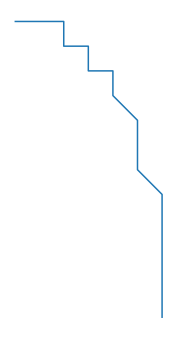

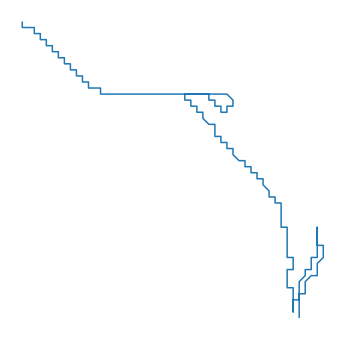

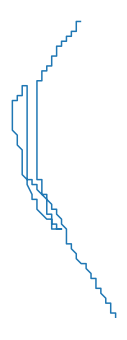

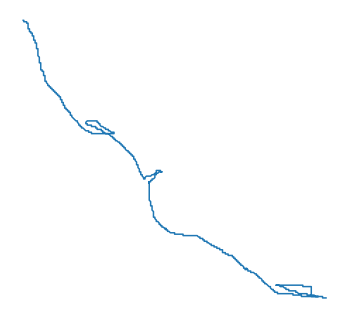

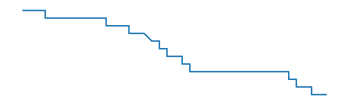

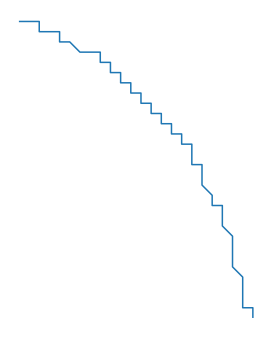

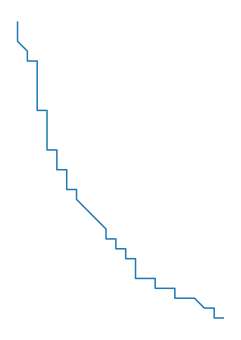

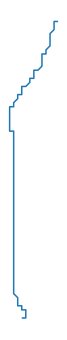

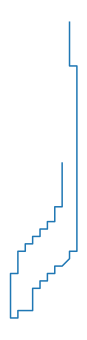

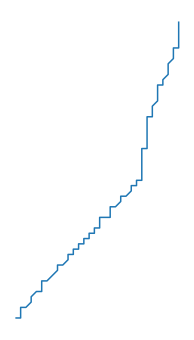

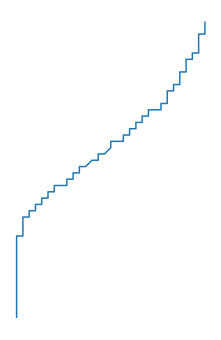

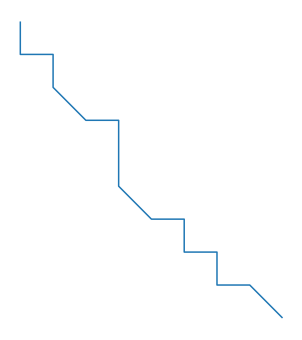

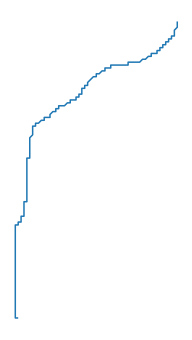

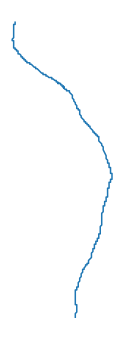

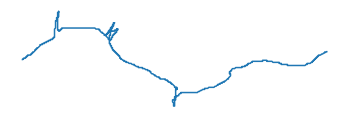

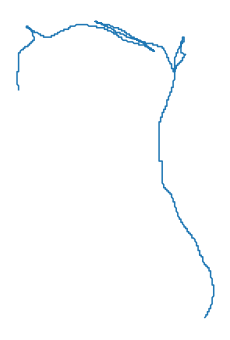

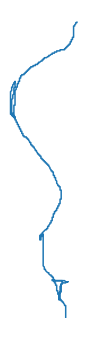

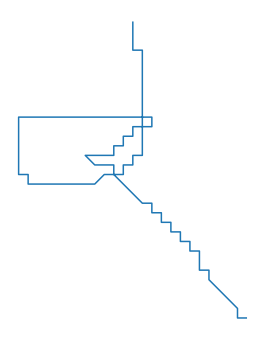

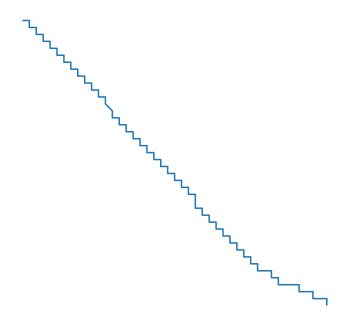

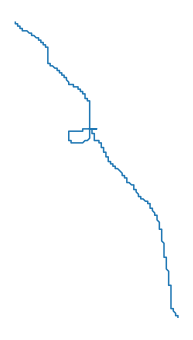

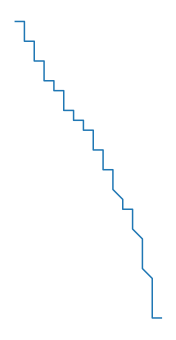

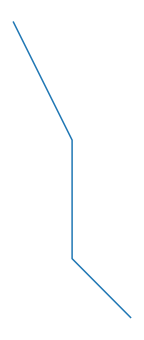

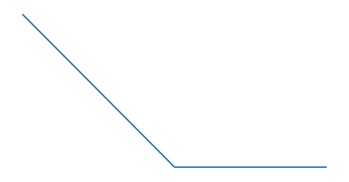

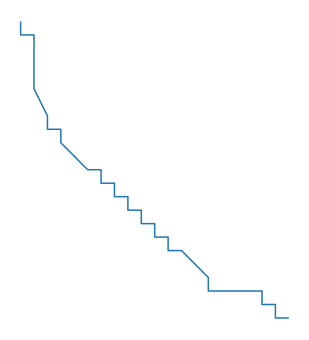

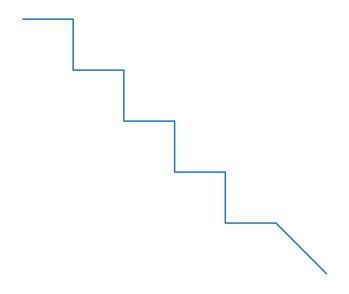

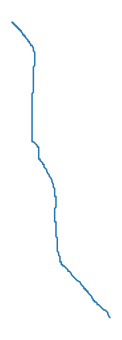

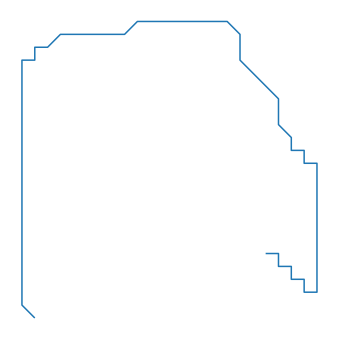

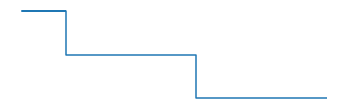

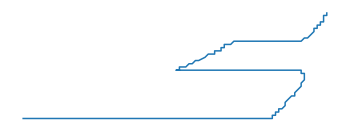

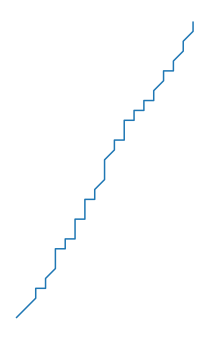

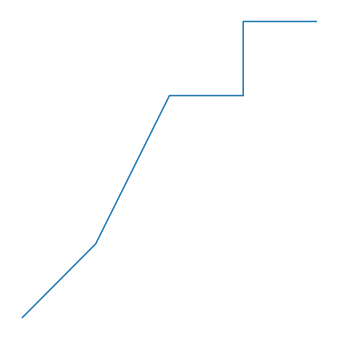

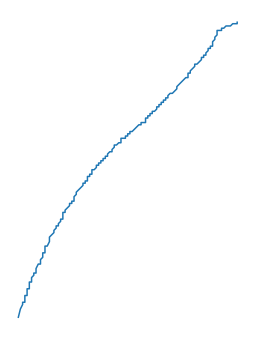

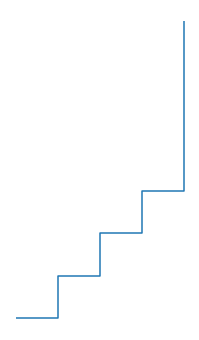

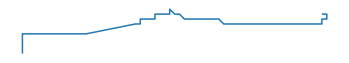

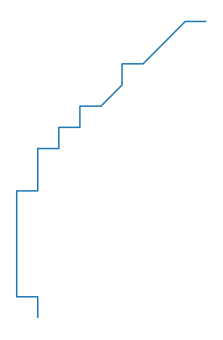

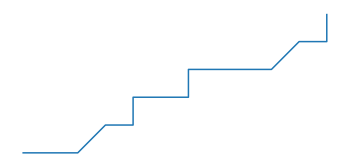

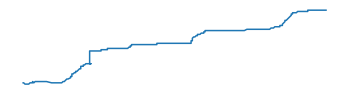

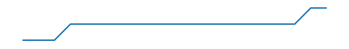

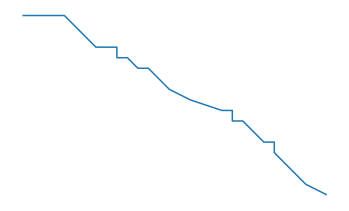

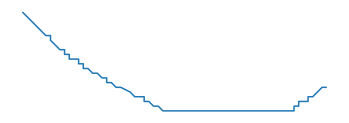

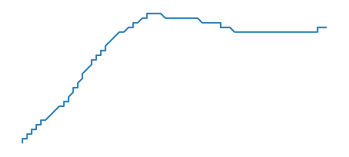

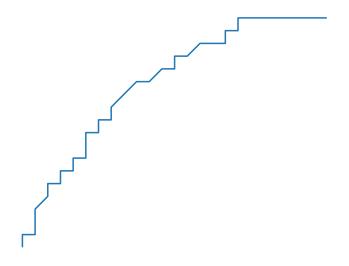

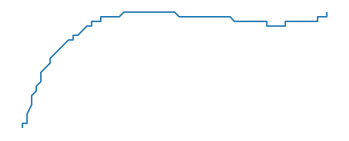

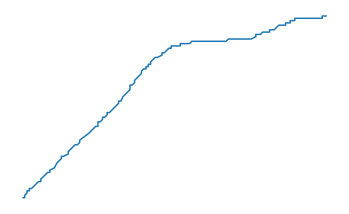

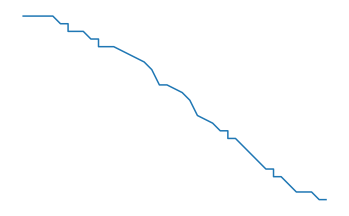

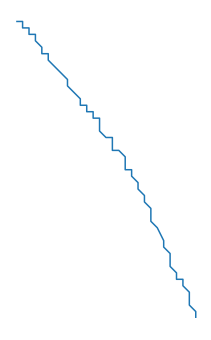

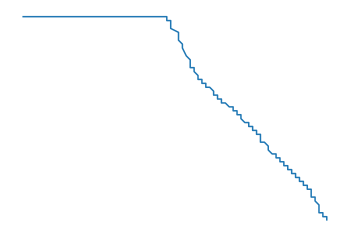

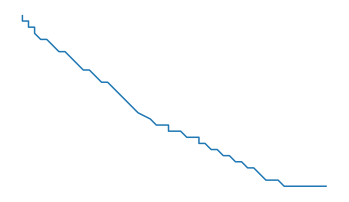

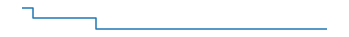

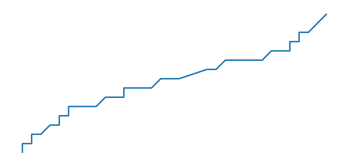

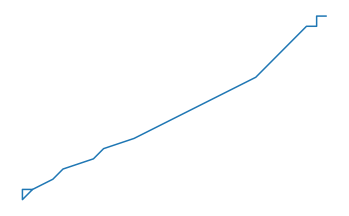

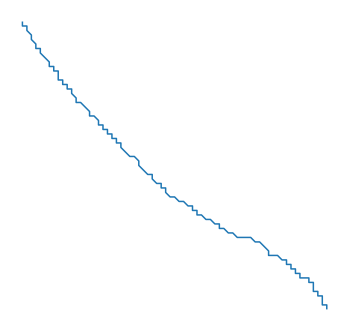

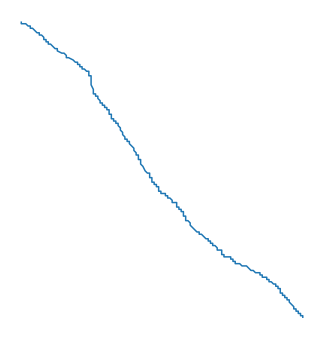

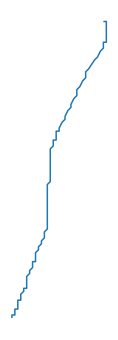

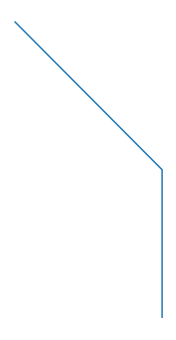

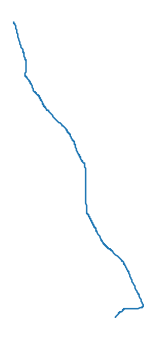

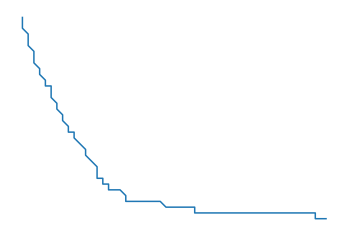

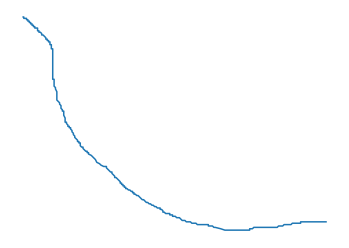

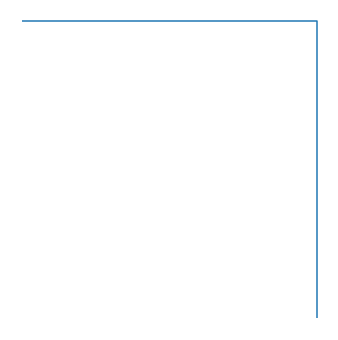

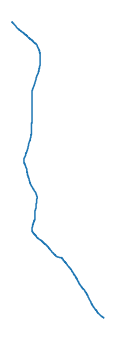

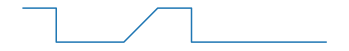

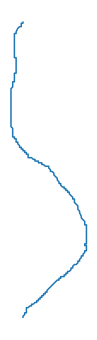

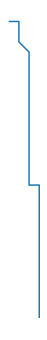

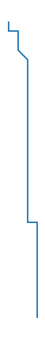

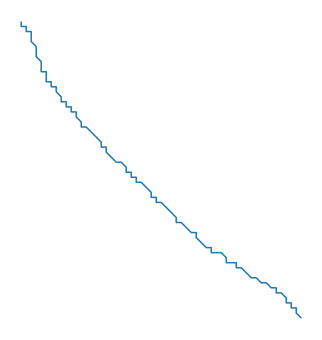

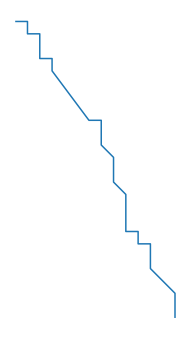

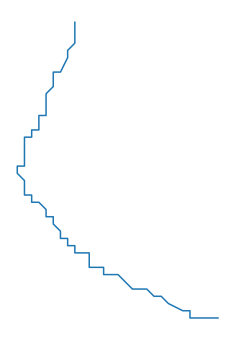

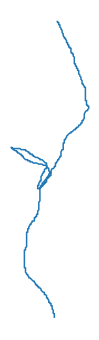

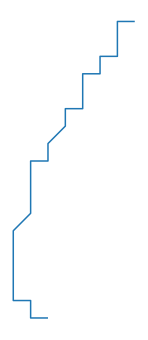

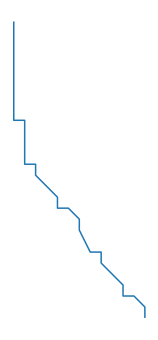

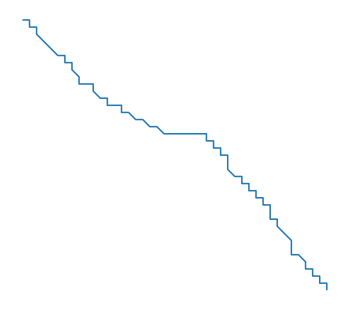

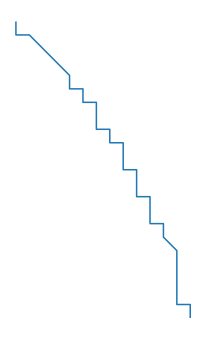

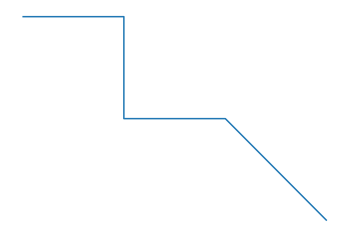

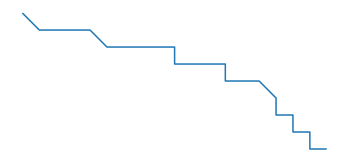

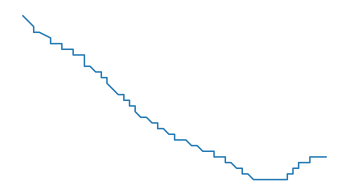

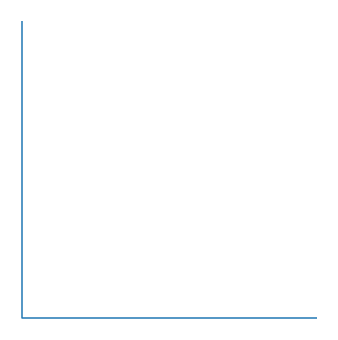

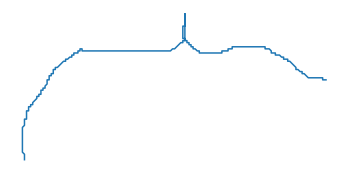

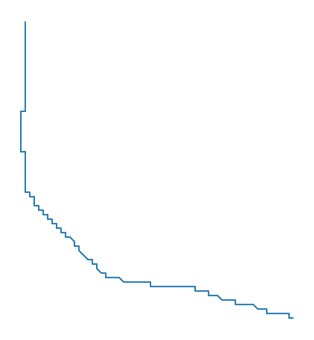

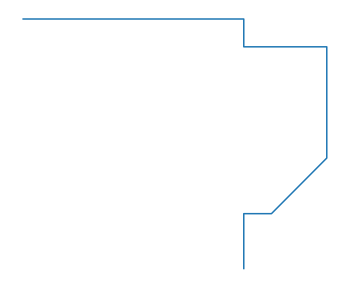

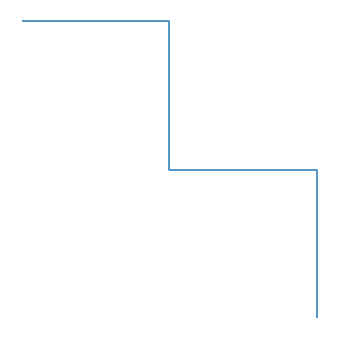

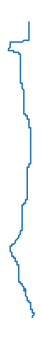

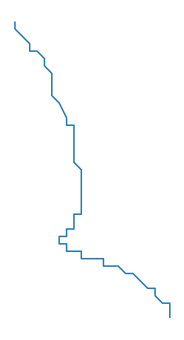

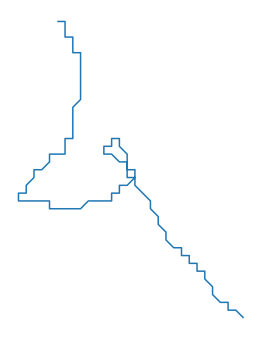

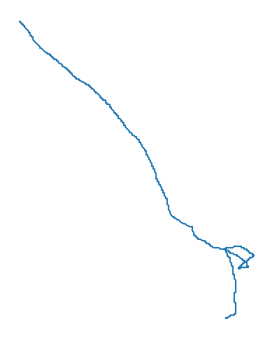

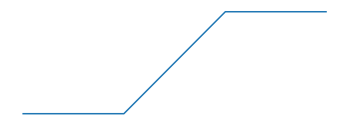

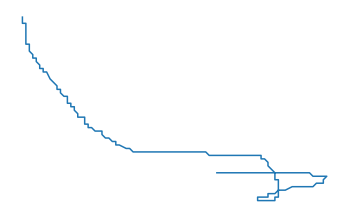

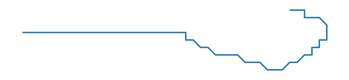

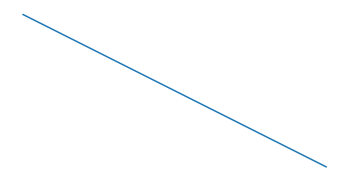

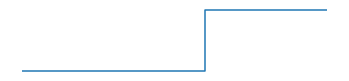

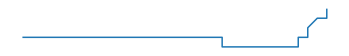

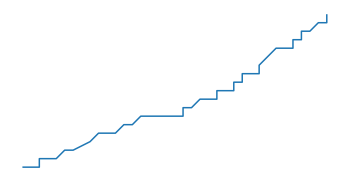

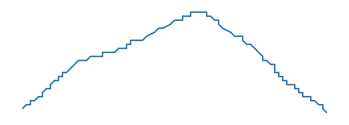

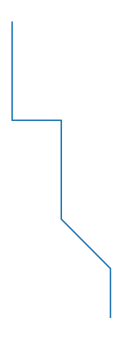

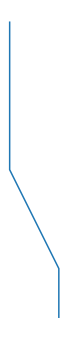

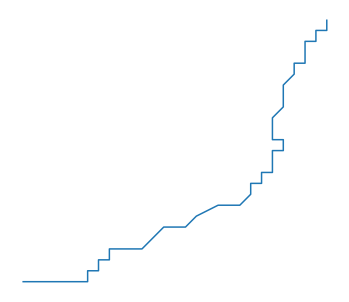

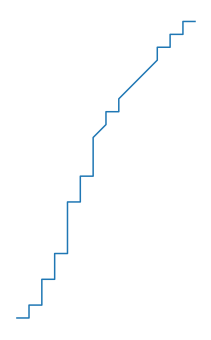

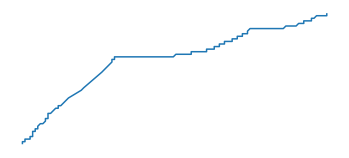

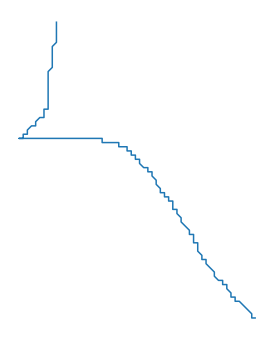

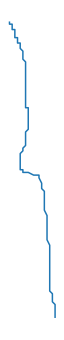

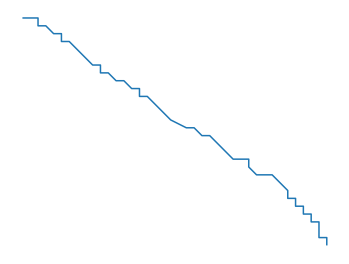

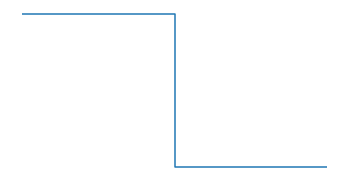

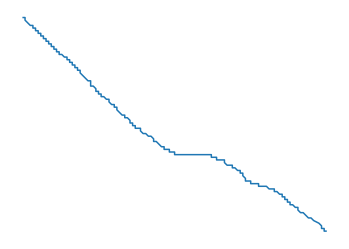

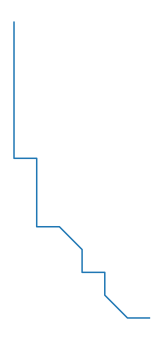

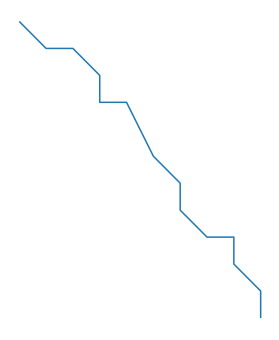

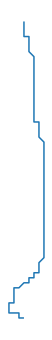

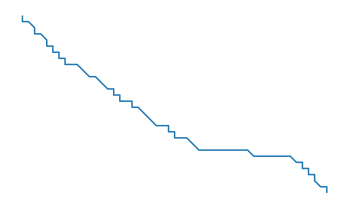

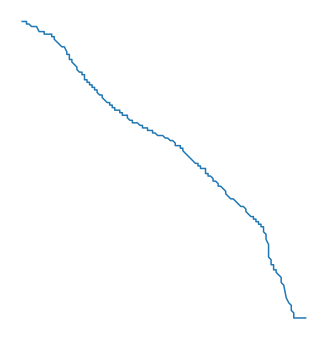

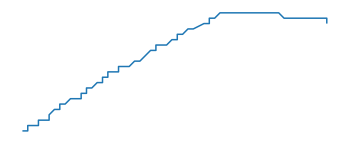

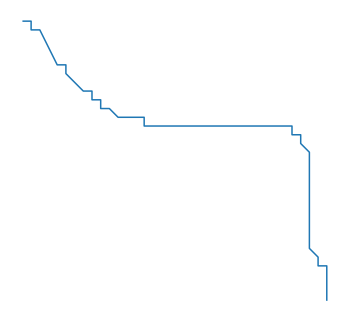

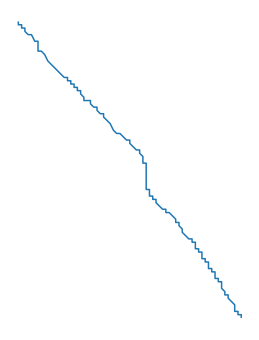

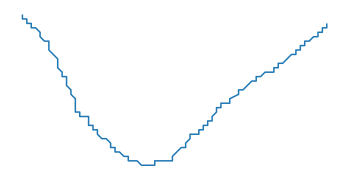

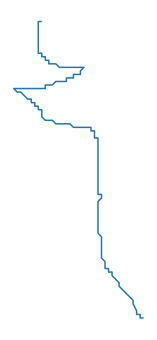

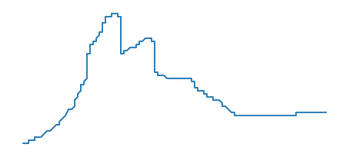

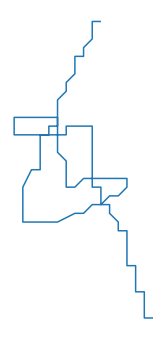

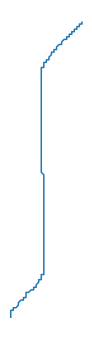

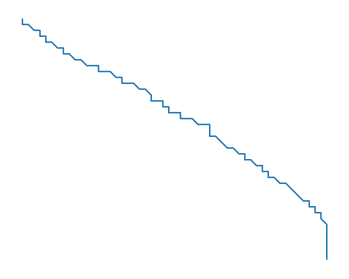

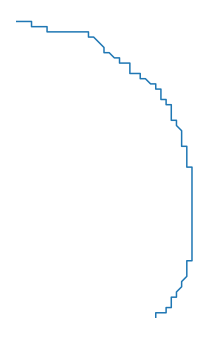

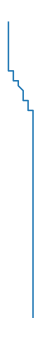

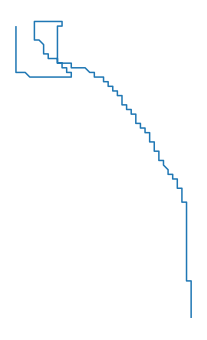

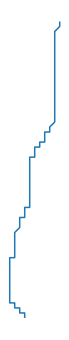

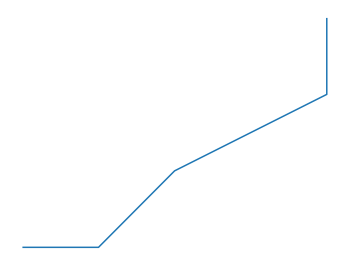

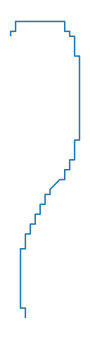

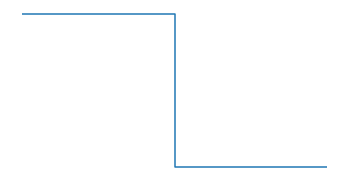

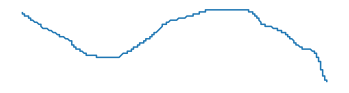

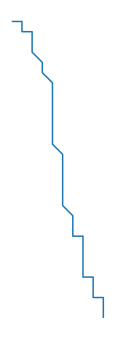

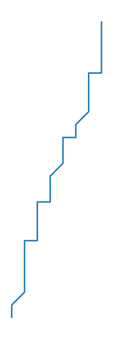

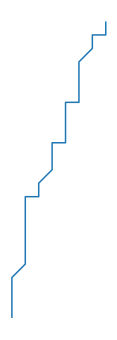

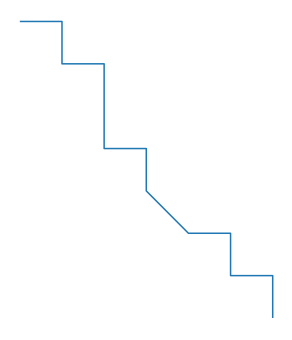

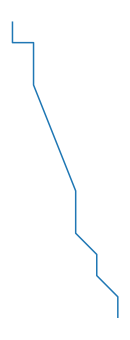

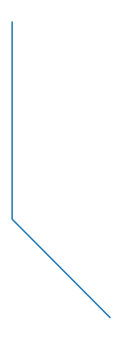

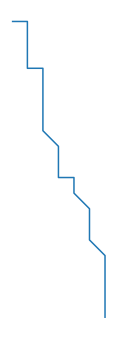

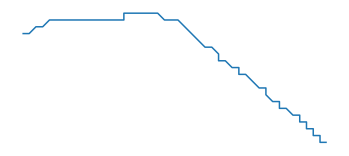

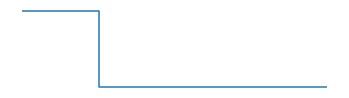

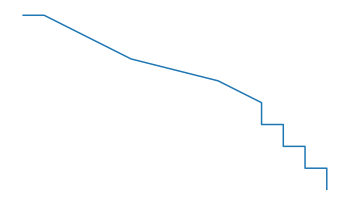

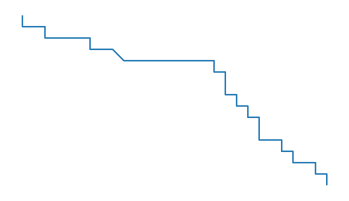

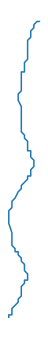

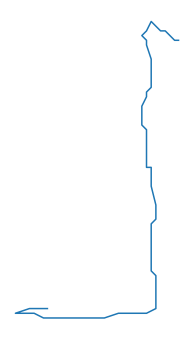

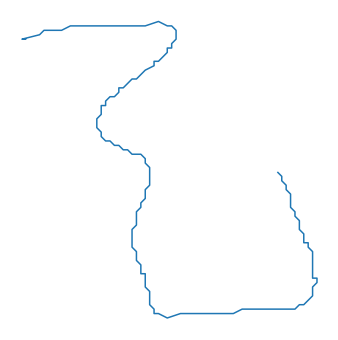

In [5]:
for index in range(line_shape.shape[0]):
    crop_extent = line_shape.loc[[index],"geometry"]
    
    # plot each extent
    fig, ax = plt.subplots(figsize = (6, 6))
    crop_extent.plot(ax=ax)
    ax.set_axis_off();

# Functional Intersection Code

In [86]:
raster_path = "/Volumes/Lacie/zhenyadata/Project_Canopy_Data/PC_Data/Sentinel_Data/Labelled/Tiles_v2_Misha/Polygon_Crops/MSK/Chips/26/full_list/"
raster_list = glob(raster_path + "/*")
vector_path = "/Volumes/Lacie/zhenyadata/Project_Canopy_Data/PC_Data/Geometry/test_line_labelling/test_line_labelling.shp"
output_path = "/Volumes/Lacie/zhenyadata/Project_Canopy_Data/PC_Data/Sentinel_Data/Labelled/Tiles_v2_Misha/Polygon_Crops/MSK/Chips/26/yes/"


vector = ogr.Open(vector_path)

# Get vector geometry
layer = vector.GetLayer()
feature_count = vector.GetLayer().GetFeatureCount()

for feature_number in range(feature_count):
    feature = layer.GetFeature(feature_number)
    vectorGeometry = feature.GetGeometryRef()

    for raster_path in raster_list:
        raster = gdal.Open(raster_path)

        # Get raster geometry
        transform = raster.GetGeoTransform()
        pixelWidth = transform[1]
        pixelHeight = transform[5]
        cols = raster.RasterXSize
        rows = raster.RasterYSize

        xLeft = transform[0]
        yTop = transform[3]
        xRight = xLeft+cols*pixelWidth
        yBottom = yTop+rows*pixelHeight

        ring = ogr.Geometry(ogr.wkbLinearRing)
        ring.AddPoint(xLeft, yTop)
        ring.AddPoint(xLeft, yBottom)
        ring.AddPoint(xRight, yBottom)
        ring.AddPoint(xRight, yTop)
        ring.AddPoint(xLeft, yTop)
        rasterGeometry = ogr.Geometry(ogr.wkbPolygon)
        rasterGeometry.AddGeometry(ring)
        
        # If intersection detected, copy chip to destination directory
        if rasterGeometry.Intersect(vectorGeometry):
            out_file = output_path + raster_path.split("/")[-1]
            copyfile(raster_path,out_file)
            raster_list.remove(raster_path)

LINESTRING (13.8659572033656 3.5533829352179,13.8660144786428 3.5533829352179,13.8660717539199 3.5533829352179,13.8661290291971 3.55332565994071,13.8661863044743 3.55332565994071,13.8662435797515 3.55332565994071,13.8663008550287 3.55326838466353,13.8663581303059 3.55326838466353,13.8663581303059 3.55326838466353,13.8664154055831 3.55326838466353,13.8665299561374 3.55326838466353,13.8665872314146 3.55321110938634,13.8666445066918 3.55321110938634,13.866701781969 3.55321110938634,13.8667590572462 3.55315383410916,13.8667590572462 3.55315383410916,13.8668163325233 3.55315383410916,13.8668163325233 3.55315383410916,13.8668736078005 3.55309655883197,13.8669308830777 3.55309655883197,13.8669308830777 3.55309655883197,13.8669308830777 3.55309655883197,13.8669881583549 3.55303928355479,13.8669881583549 3.55303928355479,13.8669881583549 3.55303928355479,13.8669881583549 3.55303928355479,13.8670454336321 3.55303928355479,13.8670454336321 3.55303928355479,13.8671027089093 3.55303928355479,13.867

# Sandbox

In [116]:
import pprint

raster_base_path = "/Volumes/Lacie/zhenyadata/Project_Canopy_Data/PC_Data/Sentinel_Data/Labelled/Tiles_v2_Misha/Polygon_Crops/MSK/Chips/full/30"
raster_list = glob(raster_base_path + "/*")
vector_path = "/Users/purgatorid/Documents/GitHub/canopy-gis/labelling/data/3_multiline.shp"
output_path = "/Volumes/Lacie/zhenyadata/Project_Canopy_Data/PC_Data/Sentinel_Data/Labelled/Tiles_v2_Misha/Polygon_Crops/MSK/Chips/yes/30/"


vector = ogr.Open(vector_path)

# Get vector geometry
layer = vector.GetLayer()
feature_count = vector.GetLayer().GetFeatureCount()

for feature_number in range(feature_count):
    feature = layer.GetFeature(feature_number)
    vectorGeometry = feature.GetGeometryRef()
    print(type(vectorGeometry))
    
#     for raster_path in raster_list:
#         raster = gdal.Open(raster_path)

#         # Get raster geometry
#         transform = raster.GetGeoTransform()
#         pixelWidth = transform[1]
#         pixelHeight = transform[5]
#         cols = raster.RasterXSize
#         rows = raster.RasterYSize

#         xLeft = transform[0]
#         yTop = transform[3]
#         xRight = xLeft+cols*pixelWidth
#         yBottom = yTop+rows*pixelHeight

#         ring = ogr.Geometry(ogr.wkbLinearRing)
#         ring.AddPoint(xLeft, yTop)
#         ring.AddPoint(xLeft, yBottom)
#         ring.AddPoint(xRight, yBottom)
#         ring.AddPoint(xRight, yTop)
#         ring.AddPoint(xLeft, yTop)
#         rasterGeometry = ogr.Geometry(ogr.wkbPolygon)
#         rasterGeometry.AddGeometry(ring)
        
#         # If intersection detected, copy chip to destination directory
#         if rasterGeometry.Intersect(vectorGeometry):
#             out_file = output_path + raster_path.split("/")[-1]
#             copyfile(raster_path,out_file)
#             raster_list.remove(raster_path)

<class 'osgeo.ogr.Geometry'>
<class 'osgeo.ogr.Geometry'>
<class 'osgeo.ogr.Geometry'>
<class 'osgeo.ogr.Geometry'>
<class 'osgeo.ogr.Geometry'>
<class 'osgeo.ogr.Geometry'>
<class 'osgeo.ogr.Geometry'>
<class 'osgeo.ogr.Geometry'>


# Function of Intersection Code

In [197]:
d = {"coords": None}

In [227]:
def output_intersecting_chips(raster_path,vector_path,output_path_yes=None,output_path_no=None,copy_chips=True):
    
    raster_list = glob(raster_path + "/*.tif")
    
    vector = ogr.Open(vector_path)
    
    geometries = {}

    geometries["yes"] = {"polygons": {"objs": [],"coords": [] } ,"points":{"objs": [],"coords":[] }}
    
    geometries["no"] = {"polygons": {"objs": [],"coords": [] } ,"points":{"objs": [],"coords":[] }}
    
    features = []

    # Get vector geometry
    layer = vector.GetLayer()
    feature_count = vector.GetLayer().GetFeatureCount()

    for feature_number in range(feature_count):
        feature = layer.GetFeature(feature_number)
        vectorGeometry = feature.GetGeometryRef()

        for raster_path in raster_list:
            raster = gdal.Open(raster_path)
    

            # Get raster geometry
            transform = raster.GetGeoTransform()
            pixelWidth = transform[1]
            pixelHeight = transform[5]
            cols = raster.RasterXSize
            rows = raster.RasterYSize

            xLeft = transform[0]
            yTop = transform[3]
            xRight = xLeft+cols*pixelWidth
            yBottom = yTop+rows*pixelHeight

            ring = ogr.Geometry(ogr.wkbLinearRing)
            ring.AddPoint(xLeft, yTop)
            ring.AddPoint(xLeft, yBottom)
            ring.AddPoint(xRight, yBottom)
            ring.AddPoint(xRight, yTop)
            ring.AddPoint(xLeft, yTop)
            rasterGeometry = ogr.Geometry(ogr.wkbPolygon)
            rasterGeometry.AddGeometry(ring)

            # If intersection detected, copy chip to destination directory
            if rasterGeometry.Intersect(vectorGeometry):
                if copy_chips:
                    out_file = output_path_yes + raster_path.split("/")[-1]
                    copyfile(raster_path,out_file)
                raster_list.remove(raster_path)
                geometries["yes"]["polygons"]["objs"].append(rasterGeometry.ExportToJson())
                geometries["yes"]["points"]["objs"].append(rasterGeometry.Centroid().ExportToJson())
    
    
    for no_raster_path in raster_list:
        
        raster = gdal.Open(no_raster_path)
        # Get raster geometry
        transform = raster.GetGeoTransform()
        pixelWidth = transform[1]
        pixelHeight = transform[5]
        cols = raster.RasterXSize
        rows = raster.RasterYSize

        xLeft = transform[0]
        yTop = transform[3]
        xRight = xLeft+cols*pixelWidth
        yBottom = yTop+rows*pixelHeight

        ring = ogr.Geometry(ogr.wkbLinearRing)
        ring.AddPoint(xLeft, yTop)
        ring.AddPoint(xLeft, yBottom)
        ring.AddPoint(xRight, yBottom)
        ring.AddPoint(xRight, yTop)
        ring.AddPoint(xLeft, yTop)
        rasterGeometry = ogr.Geometry(ogr.wkbPolygon)
        rasterGeometry.AddGeometry(ring)
        
#         polygons_no.append(rasterGeometry.ExportToJson())
        geometries["no"]["polygons"]["objs"].append(rasterGeometry.ExportToJson())
        geometries["no"]["points"]["objs"].append(rasterGeometry.Centroid().ExportToJson())
        
        
        if copy_chips:
            out_file = output_path_no + no_raster_path.split("/")[-1]
            copyfile(raster_path,out_file)

    objs_lists = { 
    1 : geometries["yes"]["polygons"]["objs"],
    2 : geometries["yes"]["points"]["objs"],  
    3 : geometries["no"]["polygons"]["objs"],
    4 : geometries["no"]["points"]["objs"]
            }
    
    coords_lists = { 
    1 : geometries["yes"]["polygons"]["coords"],
    2 : geometries["yes"]["points"]["coords"],  
    3 : geometries["no"]["polygons"]["coords"],
    4 : geometries["no"]["points"]["coords"]
            }
    
    
    for k in objs_lists:
        objs_lists[k] = list(set(objs_lists[k]))
        
    for k in coords_lists:
        if k == 1 or k == 3: 
            coords = [json.loads(i)["coordinates"][0][0][0:2] for i in objs_lists[k]] 
            coords_lists[k].append(coords)
        else:
            coords = [json.loads(i)["coordinates"] for i in geometries["yes"]["points"]["objs"]]
            coords_lists[k].append(coords)
            

    
#     coords_yes = [json.loads(i)["coordinates"][0][0][0:2] for i in polygons_yes] 
#     coords_no = [json.loads(i)["coordinates"][0][0][0:2] for i in polygons_no] 
    
#     polygons["yes"] = coords_yes
#     polygons["no"] = coords_no
    
# #     print(polygons["yes"])
    
    
#     for k,v in polygons.items():
#         for polygon in v:            
#             polygon = ee.Geometry.Polygon(v)
#             if k == "yes":
#                 feature = ee.Feature(polygon,{"class":1})
#             if k == "no":
#                 feature = ee.Feature(polygon,{"class":0})
#             features.append(feature)


    for k,v in geometries.items():
        for key in geometries[k]:
            if key == "points":
                for point in geometries[k][key]["coords"][0]:
                    point = ee.Geometry.Point(point)
                    if k == "yes":
                        feature = ee.Feature(point,{"class":1})
#                         print(feature.getInfo())
                    if k == "no":
                        feature = ee.Feature(point,{"class":0})
                    features.append(feature)
                    
                    
        
#         for polygon in v:            
#             polygon = ee.Geometry.Polygon(v)
#             if k == "yes":
#                 feature = ee.Feature(polygon,{"class":1})
#             if k == "no":
#                 feature = ee.Feature(polygon,{"class":0})
#             features.append(feature)


    fc = ee.FeatureCollection(features)
    
#     return geometries
    
    
    return fc
                
                
                
raster_path = "/Volumes/Lacie/zhenyadata/Project_Canopy_Data/PC_Data/Sentinel_Data/GEE/tiles_v3/polygon_exports/v8_dynamic_date_range_v4_native_secondary_sort_using_area/chips/full/2/"
vector_path = "/Volumes/Lacie/zhenyadata/Project_Canopy_Data/PC_Data/Geometry/test_line_labelling/v2/ISL_2-ML/ISL_Roads_2.shp"
output_path_yes = "/Volumes/Lacie/zhenyadata/Project_Canopy_Data/PC_Data/Sentinel_Data/GEE/tiles_v3/polygon_exports/v8_dynamic_date_range_v4_native_secondary_sort_using_area/chips/yes/2/"
output_path_no = "/Volumes/Lacie/zhenyadata/Project_Canopy_Data/PC_Data/Sentinel_Data/GEE/tiles_v3/polygon_exports/v8_dynamic_date_range_v4_native_secondary_sort_using_area/chips/no/2/"

In [228]:
fc = output_intersecting_chips(raster_path,vector_path,output_path_yes,output_path_no,copy_chips=False)

In [223]:
ee.Feature(ee.Geometry.Point(geometries["yes"]["points"]["coords"][0][0])).getInfo()

{'type': 'Feature',
 'geometry': {'type': 'Point',
  'coordinates': [8.974888340581318, 5.746253377927344]},
 'properties': {}}

In [205]:
for k,v in geometries.items():
    for keys in geometries[k].keys():
        print(keys)

polygons
points
polygons
points


In [97]:
len(list(set(geometries["yes"]["polygons"]["objs"])))

144

In [140]:
if k == "1" & k == "2":
    print("yay")

TypeError: unsupported operand type(s) for &: 'str' and 'int'

In [141]:
k

3

In [83]:
d = {}

d["yes"] = {"polys": [],"points":[]}
d["no"] = j



In [85]:
d["yes"]["polys"].append("junebug")

In [87]:
d["yes"]["polys"].append("jacky")

In [88]:
d

{'yes': {'polys': ['junebug', 'jacky'], 'points': []}, 'no': {}}